In [1]:
import math
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as imgshow
import numpy as np
import torch
import torchvision
from torch.autograd import Variable
import torch.distributions as tdis
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, RandomSampler, BatchSampler, DataLoader

### Load the data 

In [2]:
import csv

with open('DJI.csv') as f:
    DJI = csv.reader(f)
    DJI = list(DJI)
    DJI[0][0] = '23310.469'
    for i in range (len(DJI)):
        for j in range (len(DJI[0])):
            DJI[i][j] = float(DJI[i][j])            
print(len(DJI))

with open('HSI.csv') as f:
    HSI = csv.reader(f)
    HSI = list(HSI)
    HSI[0][0] = '25819.17'
    for i in range (len(HSI)):
        for j in range (len(HSI[0])):
            HSI[i][j] = float(HSI[i][j])            
print(len(HSI))

with open('IBEX35.csv') as f:
    IBEX35 = csv.reader(f)
    IBEX35 = list(IBEX35)
    IBEX35[0][0] = '8585.03'
    for i in range (len(IBEX35)):
        for j in range (len(IBEX35[0])):
            IBEX35[i][j] = float(IBEX35[i][j])            
print(len(IBEX35))

with open('SSGF3.csv') as f:
    SSGF3 = csv.reader(f)
    SSGF3 = list(SSGF3)
    SSGF3[0][0] = '344.268'
    for i in range (len(SSGF3)):
        for j in range (len(SSGF3[0])):
            SSGF3[i][j] = float(SSGF3[i][j])            
print(len(SSGF3))

934
743
768
779


### Prepare the data 

In [3]:
DJI_Class = [0]*924

for i in range (len(DJI_Class)):
    if DJI[i+10][2]>DJI[i+10][1]:
        DJI_Class[i]=1.0
    if DJI[i+10][2]<=DJI[i+10][1]:
        DJI_Class[i]=0.0
        
DJI_In = []
for i in range (len(DJI_Class)):
    DJI_In.append(DJI[i:i+10])
    
DJI_X = torch.tensor(DJI_In)
DJI_Y = torch.tensor(DJI_Class)

DJI_X1 = DJI_X.reshape(924,1,10,4)
DJI_Y1 = DJI_Y.reshape(924,1)

DJI_XT = DJI_X1[0:800]
DJI_XV = DJI_X1[800:]
DJI_YT = DJI_Y1[0:800]
DJI_YV = DJI_Y1[800:]

print(DJI_X1.shape)
print(DJI_Y1.shape)

torch.Size([924, 1, 10, 4])
torch.Size([924, 1])


### Construct the neural network

In [4]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 2)  
        self.conv2 = nn.Conv2d(16, 16, 2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 2)
        self.conv4 = nn.Conv2d(32, 32, 1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv5 = nn.Conv2d(32, 16, 1)
        self.conv6 = nn.Conv2d(16, 1, 1)
        self.bn3 = nn.BatchNorm2d(1)

        self.fc1 = nn.Linear(1 * 7 * 1 , 14)
        self.fc2 = nn.Linear(14 , 7)
        self.fc3 = nn.Linear(7 , 1)

        self.maxpool = nn.MaxPool2d(2, stride=2, return_indices=False, ceil_mode=False)
        self._initialize_weights()
 
    def forward(self, x1):
        x1 = F.relu(self.bn1(self.conv2(F.relu(self.conv1(x1)))))
        x2 = F.relu(self.bn2(self.conv4(F.relu(self.conv3(x1)))))
        x3 = F.relu(self.bn3(self.conv6(F.relu(self.conv5(x2)))))

        x4 = x3.view(-1, 1 * 7 * 1)
        x4 = F.relu(self.fc1(x4))
        x5 = F.relu(self.fc2(x4))
        x6 = (self.fc3(x5))

        return x6
 
 
 
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
 
 
net = CNN()

### Train the neural network

In [5]:
def CNNTrain(x=DJI_XT, y=DJI_YT, num_epochs=5, batch_size=16, model=None, lrate=0.03):
    
    X         = x       
    Y         = y                     
    opt       = optim.Adam(model.parameters(), lr=lrate)
    criterion = torch.nn.CrossEntropyLoss()
    td        = TensorDataset(X, Y)
    epoch     = 0
    
    loss_result = []

    while epoch < num_epochs: 
        for x, y in DataLoader(td, batch_size, shuffle=True, drop_last=True):   
            opt.zero_grad()
            result = model(x)
            loss   = ((result-y)**2).mean()
            print(loss)
            loss_result.append(loss)
            loss.backward()
            opt.step()
                    
        epoch += 1

    return model

In [6]:
model = CNNTrain(x=DJI_XT, y=DJI_YT, num_epochs=7000, batch_size=128, model=net, lrate=0.001)

tensor(0.3661, grad_fn=<MeanBackward0>)
tensor(0.3732, grad_fn=<MeanBackward0>)
tensor(0.3280, grad_fn=<MeanBackward0>)
tensor(0.3401, grad_fn=<MeanBackward0>)
tensor(0.3686, grad_fn=<MeanBackward0>)
tensor(0.3280, grad_fn=<MeanBackward0>)
tensor(0.3668, grad_fn=<MeanBackward0>)
tensor(0.3173, grad_fn=<MeanBackward0>)
tensor(0.3568, grad_fn=<MeanBackward0>)
tensor(0.3755, grad_fn=<MeanBackward0>)
tensor(0.3324, grad_fn=<MeanBackward0>)
tensor(0.3349, grad_fn=<MeanBackward0>)
tensor(0.3465, grad_fn=<MeanBackward0>)
tensor(0.3455, grad_fn=<MeanBackward0>)
tensor(0.2863, grad_fn=<MeanBackward0>)
tensor(0.3631, grad_fn=<MeanBackward0>)
tensor(0.3499, grad_fn=<MeanBackward0>)
tensor(0.3493, grad_fn=<MeanBackward0>)
tensor(0.3386, grad_fn=<MeanBackward0>)
tensor(0.3741, grad_fn=<MeanBackward0>)
tensor(0.3296, grad_fn=<MeanBackward0>)
tensor(0.3286, grad_fn=<MeanBackward0>)
tensor(0.3275, grad_fn=<MeanBackward0>)
tensor(0.3259, grad_fn=<MeanBackward0>)
tensor(0.3365, grad_fn=<MeanBackward0>)


tensor(0.2354, grad_fn=<MeanBackward0>)
tensor(0.2222, grad_fn=<MeanBackward0>)
tensor(0.2406, grad_fn=<MeanBackward0>)
tensor(0.2305, grad_fn=<MeanBackward0>)
tensor(0.2437, grad_fn=<MeanBackward0>)
tensor(0.2438, grad_fn=<MeanBackward0>)
tensor(0.2336, grad_fn=<MeanBackward0>)
tensor(0.2283, grad_fn=<MeanBackward0>)
tensor(0.2482, grad_fn=<MeanBackward0>)
tensor(0.2502, grad_fn=<MeanBackward0>)
tensor(0.2380, grad_fn=<MeanBackward0>)
tensor(0.2306, grad_fn=<MeanBackward0>)
tensor(0.2374, grad_fn=<MeanBackward0>)
tensor(0.2370, grad_fn=<MeanBackward0>)
tensor(0.2300, grad_fn=<MeanBackward0>)
tensor(0.2424, grad_fn=<MeanBackward0>)
tensor(0.2381, grad_fn=<MeanBackward0>)
tensor(0.2318, grad_fn=<MeanBackward0>)
tensor(0.2209, grad_fn=<MeanBackward0>)
tensor(0.2376, grad_fn=<MeanBackward0>)
tensor(0.2235, grad_fn=<MeanBackward0>)
tensor(0.2488, grad_fn=<MeanBackward0>)
tensor(0.2263, grad_fn=<MeanBackward0>)
tensor(0.2411, grad_fn=<MeanBackward0>)
tensor(0.2541, grad_fn=<MeanBackward0>)


tensor(0.2127, grad_fn=<MeanBackward0>)
tensor(0.2003, grad_fn=<MeanBackward0>)
tensor(0.1943, grad_fn=<MeanBackward0>)
tensor(0.2140, grad_fn=<MeanBackward0>)
tensor(0.2281, grad_fn=<MeanBackward0>)
tensor(0.2112, grad_fn=<MeanBackward0>)
tensor(0.2053, grad_fn=<MeanBackward0>)
tensor(0.2255, grad_fn=<MeanBackward0>)
tensor(0.2052, grad_fn=<MeanBackward0>)
tensor(0.2301, grad_fn=<MeanBackward0>)
tensor(0.2111, grad_fn=<MeanBackward0>)
tensor(0.2207, grad_fn=<MeanBackward0>)
tensor(0.2074, grad_fn=<MeanBackward0>)
tensor(0.2087, grad_fn=<MeanBackward0>)
tensor(0.2144, grad_fn=<MeanBackward0>)
tensor(0.1957, grad_fn=<MeanBackward0>)
tensor(0.2036, grad_fn=<MeanBackward0>)
tensor(0.2066, grad_fn=<MeanBackward0>)
tensor(0.2026, grad_fn=<MeanBackward0>)
tensor(0.2108, grad_fn=<MeanBackward0>)
tensor(0.2277, grad_fn=<MeanBackward0>)
tensor(0.2064, grad_fn=<MeanBackward0>)
tensor(0.2103, grad_fn=<MeanBackward0>)
tensor(0.2209, grad_fn=<MeanBackward0>)
tensor(0.1826, grad_fn=<MeanBackward0>)


tensor(0.2032, grad_fn=<MeanBackward0>)
tensor(0.2056, grad_fn=<MeanBackward0>)
tensor(0.2130, grad_fn=<MeanBackward0>)
tensor(0.2032, grad_fn=<MeanBackward0>)
tensor(0.1732, grad_fn=<MeanBackward0>)
tensor(0.1924, grad_fn=<MeanBackward0>)
tensor(0.1795, grad_fn=<MeanBackward0>)
tensor(0.1892, grad_fn=<MeanBackward0>)
tensor(0.2002, grad_fn=<MeanBackward0>)
tensor(0.1856, grad_fn=<MeanBackward0>)
tensor(0.1805, grad_fn=<MeanBackward0>)
tensor(0.1786, grad_fn=<MeanBackward0>)
tensor(0.1856, grad_fn=<MeanBackward0>)
tensor(0.1788, grad_fn=<MeanBackward0>)
tensor(0.1657, grad_fn=<MeanBackward0>)
tensor(0.1757, grad_fn=<MeanBackward0>)
tensor(0.1702, grad_fn=<MeanBackward0>)
tensor(0.2096, grad_fn=<MeanBackward0>)
tensor(0.2154, grad_fn=<MeanBackward0>)
tensor(0.1824, grad_fn=<MeanBackward0>)
tensor(0.1789, grad_fn=<MeanBackward0>)
tensor(0.1742, grad_fn=<MeanBackward0>)
tensor(0.1993, grad_fn=<MeanBackward0>)
tensor(0.2145, grad_fn=<MeanBackward0>)
tensor(0.1668, grad_fn=<MeanBackward0>)


tensor(0.1700, grad_fn=<MeanBackward0>)
tensor(0.1544, grad_fn=<MeanBackward0>)
tensor(0.1537, grad_fn=<MeanBackward0>)
tensor(0.1464, grad_fn=<MeanBackward0>)
tensor(0.1612, grad_fn=<MeanBackward0>)
tensor(0.1660, grad_fn=<MeanBackward0>)
tensor(0.2075, grad_fn=<MeanBackward0>)
tensor(0.1808, grad_fn=<MeanBackward0>)
tensor(0.1904, grad_fn=<MeanBackward0>)
tensor(0.1684, grad_fn=<MeanBackward0>)
tensor(0.1916, grad_fn=<MeanBackward0>)
tensor(0.1579, grad_fn=<MeanBackward0>)
tensor(0.1523, grad_fn=<MeanBackward0>)
tensor(0.1696, grad_fn=<MeanBackward0>)
tensor(0.2015, grad_fn=<MeanBackward0>)
tensor(0.1729, grad_fn=<MeanBackward0>)
tensor(0.1846, grad_fn=<MeanBackward0>)
tensor(0.1615, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.2043, grad_fn=<MeanBackward0>)
tensor(0.1792, grad_fn=<MeanBackward0>)
tensor(0.1685, grad_fn=<MeanBackward0>)
tensor(0.2141, grad_fn=<MeanBackward0>)
tensor(0.1509, grad_fn=<MeanBackward0>)
tensor(0.1673, grad_fn=<MeanBackward0>)


tensor(0.1582, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.1603, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.1503, grad_fn=<MeanBackward0>)
tensor(0.1479, grad_fn=<MeanBackward0>)
tensor(0.1810, grad_fn=<MeanBackward0>)
tensor(0.1477, grad_fn=<MeanBackward0>)
tensor(0.1987, grad_fn=<MeanBackward0>)
tensor(0.1655, grad_fn=<MeanBackward0>)
tensor(0.1443, grad_fn=<MeanBackward0>)
tensor(0.1816, grad_fn=<MeanBackward0>)
tensor(0.1378, grad_fn=<MeanBackward0>)
tensor(0.2218, grad_fn=<MeanBackward0>)
tensor(0.1551, grad_fn=<MeanBackward0>)
tensor(0.1497, grad_fn=<MeanBackward0>)
tensor(0.1579, grad_fn=<MeanBackward0>)
tensor(0.1531, grad_fn=<MeanBackward0>)
tensor(0.1819, grad_fn=<MeanBackward0>)
tensor(0.1469, grad_fn=<MeanBackward0>)
tensor(0.1077, grad_fn=<MeanBackward0>)
tensor(0.1608, grad_fn=<MeanBackward0>)
tensor(0.1739, grad_fn=<MeanBackward0>)
tensor(0.1578, grad_fn=<MeanBackward0>)
tensor(0.1771, grad_fn=<MeanBackward0>)


tensor(0.1540, grad_fn=<MeanBackward0>)
tensor(0.1297, grad_fn=<MeanBackward0>)
tensor(0.1437, grad_fn=<MeanBackward0>)
tensor(0.1722, grad_fn=<MeanBackward0>)
tensor(0.1645, grad_fn=<MeanBackward0>)
tensor(0.1852, grad_fn=<MeanBackward0>)
tensor(0.1521, grad_fn=<MeanBackward0>)
tensor(0.1421, grad_fn=<MeanBackward0>)
tensor(0.1677, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.1381, grad_fn=<MeanBackward0>)
tensor(0.1454, grad_fn=<MeanBackward0>)
tensor(0.1434, grad_fn=<MeanBackward0>)
tensor(0.1763, grad_fn=<MeanBackward0>)
tensor(0.1404, grad_fn=<MeanBackward0>)
tensor(0.1679, grad_fn=<MeanBackward0>)
tensor(0.1302, grad_fn=<MeanBackward0>)
tensor(0.1507, grad_fn=<MeanBackward0>)
tensor(0.1232, grad_fn=<MeanBackward0>)
tensor(0.1485, grad_fn=<MeanBackward0>)
tensor(0.1384, grad_fn=<MeanBackward0>)
tensor(0.1500, grad_fn=<MeanBackward0>)
tensor(0.1316, grad_fn=<MeanBackward0>)
tensor(0.1472, grad_fn=<MeanBackward0>)
tensor(0.1196, grad_fn=<MeanBackward0>)


tensor(0.1508, grad_fn=<MeanBackward0>)
tensor(0.1704, grad_fn=<MeanBackward0>)
tensor(0.1459, grad_fn=<MeanBackward0>)
tensor(0.1604, grad_fn=<MeanBackward0>)
tensor(0.1402, grad_fn=<MeanBackward0>)
tensor(0.1392, grad_fn=<MeanBackward0>)
tensor(0.1595, grad_fn=<MeanBackward0>)
tensor(0.1203, grad_fn=<MeanBackward0>)
tensor(0.2041, grad_fn=<MeanBackward0>)
tensor(0.1381, grad_fn=<MeanBackward0>)
tensor(0.1778, grad_fn=<MeanBackward0>)
tensor(0.1834, grad_fn=<MeanBackward0>)
tensor(0.1276, grad_fn=<MeanBackward0>)
tensor(0.1206, grad_fn=<MeanBackward0>)
tensor(0.1400, grad_fn=<MeanBackward0>)
tensor(0.1357, grad_fn=<MeanBackward0>)
tensor(0.1381, grad_fn=<MeanBackward0>)
tensor(0.1424, grad_fn=<MeanBackward0>)
tensor(0.1597, grad_fn=<MeanBackward0>)
tensor(0.1233, grad_fn=<MeanBackward0>)
tensor(0.1429, grad_fn=<MeanBackward0>)
tensor(0.1550, grad_fn=<MeanBackward0>)
tensor(0.1352, grad_fn=<MeanBackward0>)
tensor(0.1222, grad_fn=<MeanBackward0>)
tensor(0.1288, grad_fn=<MeanBackward0>)


tensor(0.1240, grad_fn=<MeanBackward0>)
tensor(0.1360, grad_fn=<MeanBackward0>)
tensor(0.1450, grad_fn=<MeanBackward0>)
tensor(0.1173, grad_fn=<MeanBackward0>)
tensor(0.1395, grad_fn=<MeanBackward0>)
tensor(0.1414, grad_fn=<MeanBackward0>)
tensor(0.1224, grad_fn=<MeanBackward0>)
tensor(0.1100, grad_fn=<MeanBackward0>)
tensor(0.1243, grad_fn=<MeanBackward0>)
tensor(0.1216, grad_fn=<MeanBackward0>)
tensor(0.1200, grad_fn=<MeanBackward0>)
tensor(0.1185, grad_fn=<MeanBackward0>)
tensor(0.1461, grad_fn=<MeanBackward0>)
tensor(0.1182, grad_fn=<MeanBackward0>)
tensor(0.1091, grad_fn=<MeanBackward0>)
tensor(0.1219, grad_fn=<MeanBackward0>)
tensor(0.1619, grad_fn=<MeanBackward0>)
tensor(0.1390, grad_fn=<MeanBackward0>)
tensor(0.1062, grad_fn=<MeanBackward0>)
tensor(0.1233, grad_fn=<MeanBackward0>)
tensor(0.1278, grad_fn=<MeanBackward0>)
tensor(0.1211, grad_fn=<MeanBackward0>)
tensor(0.1243, grad_fn=<MeanBackward0>)
tensor(0.1337, grad_fn=<MeanBackward0>)
tensor(0.0951, grad_fn=<MeanBackward0>)


tensor(0.1378, grad_fn=<MeanBackward0>)
tensor(0.1178, grad_fn=<MeanBackward0>)
tensor(0.1548, grad_fn=<MeanBackward0>)
tensor(0.0964, grad_fn=<MeanBackward0>)
tensor(0.1283, grad_fn=<MeanBackward0>)
tensor(0.1118, grad_fn=<MeanBackward0>)
tensor(0.1391, grad_fn=<MeanBackward0>)
tensor(0.1076, grad_fn=<MeanBackward0>)
tensor(0.1236, grad_fn=<MeanBackward0>)
tensor(0.1175, grad_fn=<MeanBackward0>)
tensor(0.1051, grad_fn=<MeanBackward0>)
tensor(0.1050, grad_fn=<MeanBackward0>)
tensor(0.1131, grad_fn=<MeanBackward0>)
tensor(0.1080, grad_fn=<MeanBackward0>)
tensor(0.1706, grad_fn=<MeanBackward0>)
tensor(0.1566, grad_fn=<MeanBackward0>)
tensor(0.1158, grad_fn=<MeanBackward0>)
tensor(0.1136, grad_fn=<MeanBackward0>)
tensor(0.1137, grad_fn=<MeanBackward0>)
tensor(0.0920, grad_fn=<MeanBackward0>)
tensor(0.1280, grad_fn=<MeanBackward0>)
tensor(0.1131, grad_fn=<MeanBackward0>)
tensor(0.1297, grad_fn=<MeanBackward0>)
tensor(0.0918, grad_fn=<MeanBackward0>)
tensor(0.0934, grad_fn=<MeanBackward0>)


tensor(0.1145, grad_fn=<MeanBackward0>)
tensor(0.0973, grad_fn=<MeanBackward0>)
tensor(0.0948, grad_fn=<MeanBackward0>)
tensor(0.0922, grad_fn=<MeanBackward0>)
tensor(0.1213, grad_fn=<MeanBackward0>)
tensor(0.1582, grad_fn=<MeanBackward0>)
tensor(0.0882, grad_fn=<MeanBackward0>)
tensor(0.1058, grad_fn=<MeanBackward0>)
tensor(0.1248, grad_fn=<MeanBackward0>)
tensor(0.1232, grad_fn=<MeanBackward0>)
tensor(0.1281, grad_fn=<MeanBackward0>)
tensor(0.1119, grad_fn=<MeanBackward0>)
tensor(0.1175, grad_fn=<MeanBackward0>)
tensor(0.1179, grad_fn=<MeanBackward0>)
tensor(0.0934, grad_fn=<MeanBackward0>)
tensor(0.1081, grad_fn=<MeanBackward0>)
tensor(0.1361, grad_fn=<MeanBackward0>)
tensor(0.1249, grad_fn=<MeanBackward0>)
tensor(0.1211, grad_fn=<MeanBackward0>)
tensor(0.1243, grad_fn=<MeanBackward0>)
tensor(0.1083, grad_fn=<MeanBackward0>)
tensor(0.0967, grad_fn=<MeanBackward0>)
tensor(0.1146, grad_fn=<MeanBackward0>)
tensor(0.1252, grad_fn=<MeanBackward0>)
tensor(0.1066, grad_fn=<MeanBackward0>)


tensor(0.0870, grad_fn=<MeanBackward0>)
tensor(0.1281, grad_fn=<MeanBackward0>)
tensor(0.1204, grad_fn=<MeanBackward0>)
tensor(0.1114, grad_fn=<MeanBackward0>)
tensor(0.1387, grad_fn=<MeanBackward0>)
tensor(0.0898, grad_fn=<MeanBackward0>)
tensor(0.0983, grad_fn=<MeanBackward0>)
tensor(0.0975, grad_fn=<MeanBackward0>)
tensor(0.1193, grad_fn=<MeanBackward0>)
tensor(0.1233, grad_fn=<MeanBackward0>)
tensor(0.0982, grad_fn=<MeanBackward0>)
tensor(0.0880, grad_fn=<MeanBackward0>)
tensor(0.0791, grad_fn=<MeanBackward0>)
tensor(0.2307, grad_fn=<MeanBackward0>)
tensor(0.1170, grad_fn=<MeanBackward0>)
tensor(0.1203, grad_fn=<MeanBackward0>)
tensor(0.1035, grad_fn=<MeanBackward0>)
tensor(0.1011, grad_fn=<MeanBackward0>)
tensor(0.1166, grad_fn=<MeanBackward0>)
tensor(0.0923, grad_fn=<MeanBackward0>)
tensor(0.1113, grad_fn=<MeanBackward0>)
tensor(0.1229, grad_fn=<MeanBackward0>)
tensor(0.1344, grad_fn=<MeanBackward0>)
tensor(0.1014, grad_fn=<MeanBackward0>)
tensor(0.1052, grad_fn=<MeanBackward0>)


tensor(0.1284, grad_fn=<MeanBackward0>)
tensor(0.1027, grad_fn=<MeanBackward0>)
tensor(0.0950, grad_fn=<MeanBackward0>)
tensor(0.0704, grad_fn=<MeanBackward0>)
tensor(0.0944, grad_fn=<MeanBackward0>)
tensor(0.1171, grad_fn=<MeanBackward0>)
tensor(0.1128, grad_fn=<MeanBackward0>)
tensor(0.1103, grad_fn=<MeanBackward0>)
tensor(0.1351, grad_fn=<MeanBackward0>)
tensor(0.1464, grad_fn=<MeanBackward0>)
tensor(0.1091, grad_fn=<MeanBackward0>)
tensor(0.0998, grad_fn=<MeanBackward0>)
tensor(0.1811, grad_fn=<MeanBackward0>)
tensor(0.0873, grad_fn=<MeanBackward0>)
tensor(0.0825, grad_fn=<MeanBackward0>)
tensor(0.1754, grad_fn=<MeanBackward0>)
tensor(0.1142, grad_fn=<MeanBackward0>)
tensor(0.1097, grad_fn=<MeanBackward0>)
tensor(0.1232, grad_fn=<MeanBackward0>)
tensor(0.1071, grad_fn=<MeanBackward0>)
tensor(0.0918, grad_fn=<MeanBackward0>)
tensor(0.0906, grad_fn=<MeanBackward0>)
tensor(0.0930, grad_fn=<MeanBackward0>)
tensor(0.1004, grad_fn=<MeanBackward0>)
tensor(0.1053, grad_fn=<MeanBackward0>)


tensor(0.1550, grad_fn=<MeanBackward0>)
tensor(0.1206, grad_fn=<MeanBackward0>)
tensor(0.0909, grad_fn=<MeanBackward0>)
tensor(0.1304, grad_fn=<MeanBackward0>)
tensor(0.0953, grad_fn=<MeanBackward0>)
tensor(0.1187, grad_fn=<MeanBackward0>)
tensor(0.1050, grad_fn=<MeanBackward0>)
tensor(0.1106, grad_fn=<MeanBackward0>)
tensor(0.1193, grad_fn=<MeanBackward0>)
tensor(0.1461, grad_fn=<MeanBackward0>)
tensor(0.0885, grad_fn=<MeanBackward0>)
tensor(0.1107, grad_fn=<MeanBackward0>)
tensor(0.1123, grad_fn=<MeanBackward0>)
tensor(0.0852, grad_fn=<MeanBackward0>)
tensor(0.0998, grad_fn=<MeanBackward0>)
tensor(0.1019, grad_fn=<MeanBackward0>)
tensor(0.0997, grad_fn=<MeanBackward0>)
tensor(0.0997, grad_fn=<MeanBackward0>)
tensor(0.0919, grad_fn=<MeanBackward0>)
tensor(0.1034, grad_fn=<MeanBackward0>)
tensor(0.1119, grad_fn=<MeanBackward0>)
tensor(0.1037, grad_fn=<MeanBackward0>)
tensor(0.1265, grad_fn=<MeanBackward0>)
tensor(0.1121, grad_fn=<MeanBackward0>)
tensor(0.0747, grad_fn=<MeanBackward0>)


tensor(0.0771, grad_fn=<MeanBackward0>)
tensor(0.1009, grad_fn=<MeanBackward0>)
tensor(0.0779, grad_fn=<MeanBackward0>)
tensor(0.1022, grad_fn=<MeanBackward0>)
tensor(0.0963, grad_fn=<MeanBackward0>)
tensor(0.0930, grad_fn=<MeanBackward0>)
tensor(0.0811, grad_fn=<MeanBackward0>)
tensor(0.1476, grad_fn=<MeanBackward0>)
tensor(0.0954, grad_fn=<MeanBackward0>)
tensor(0.1053, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0890, grad_fn=<MeanBackward0>)
tensor(0.0996, grad_fn=<MeanBackward0>)
tensor(0.1222, grad_fn=<MeanBackward0>)
tensor(0.1343, grad_fn=<MeanBackward0>)
tensor(0.1549, grad_fn=<MeanBackward0>)
tensor(0.0894, grad_fn=<MeanBackward0>)
tensor(0.1151, grad_fn=<MeanBackward0>)
tensor(0.0828, grad_fn=<MeanBackward0>)
tensor(0.1093, grad_fn=<MeanBackward0>)
tensor(0.0781, grad_fn=<MeanBackward0>)
tensor(0.1018, grad_fn=<MeanBackward0>)
tensor(0.1061, grad_fn=<MeanBackward0>)
tensor(0.1070, grad_fn=<MeanBackward0>)
tensor(0.0948, grad_fn=<MeanBackward0>)


tensor(0.1692, grad_fn=<MeanBackward0>)
tensor(0.0909, grad_fn=<MeanBackward0>)
tensor(0.1040, grad_fn=<MeanBackward0>)
tensor(0.0926, grad_fn=<MeanBackward0>)
tensor(0.0785, grad_fn=<MeanBackward0>)
tensor(0.0785, grad_fn=<MeanBackward0>)
tensor(0.1133, grad_fn=<MeanBackward0>)
tensor(0.0827, grad_fn=<MeanBackward0>)
tensor(0.0746, grad_fn=<MeanBackward0>)
tensor(0.0929, grad_fn=<MeanBackward0>)
tensor(0.0844, grad_fn=<MeanBackward0>)
tensor(0.0940, grad_fn=<MeanBackward0>)
tensor(0.0904, grad_fn=<MeanBackward0>)
tensor(0.0988, grad_fn=<MeanBackward0>)
tensor(0.1714, grad_fn=<MeanBackward0>)
tensor(0.0708, grad_fn=<MeanBackward0>)
tensor(0.0851, grad_fn=<MeanBackward0>)
tensor(0.0914, grad_fn=<MeanBackward0>)
tensor(0.0858, grad_fn=<MeanBackward0>)
tensor(0.0810, grad_fn=<MeanBackward0>)
tensor(0.1208, grad_fn=<MeanBackward0>)
tensor(0.1035, grad_fn=<MeanBackward0>)
tensor(0.0956, grad_fn=<MeanBackward0>)
tensor(0.0963, grad_fn=<MeanBackward0>)
tensor(0.0833, grad_fn=<MeanBackward0>)


tensor(0.0884, grad_fn=<MeanBackward0>)
tensor(0.0942, grad_fn=<MeanBackward0>)
tensor(0.0891, grad_fn=<MeanBackward0>)
tensor(0.0951, grad_fn=<MeanBackward0>)
tensor(0.1025, grad_fn=<MeanBackward0>)
tensor(0.0714, grad_fn=<MeanBackward0>)
tensor(0.1388, grad_fn=<MeanBackward0>)
tensor(0.0705, grad_fn=<MeanBackward0>)
tensor(0.0695, grad_fn=<MeanBackward0>)
tensor(0.0936, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0772, grad_fn=<MeanBackward0>)
tensor(0.1319, grad_fn=<MeanBackward0>)
tensor(0.1033, grad_fn=<MeanBackward0>)
tensor(0.1158, grad_fn=<MeanBackward0>)
tensor(0.0933, grad_fn=<MeanBackward0>)
tensor(0.0829, grad_fn=<MeanBackward0>)
tensor(0.0892, grad_fn=<MeanBackward0>)
tensor(0.0733, grad_fn=<MeanBackward0>)
tensor(0.0748, grad_fn=<MeanBackward0>)
tensor(0.1113, grad_fn=<MeanBackward0>)
tensor(0.0844, grad_fn=<MeanBackward0>)
tensor(0.0946, grad_fn=<MeanBackward0>)
tensor(0.0779, grad_fn=<MeanBackward0>)
tensor(0.1105, grad_fn=<MeanBackward0>)


tensor(0.1458, grad_fn=<MeanBackward0>)
tensor(0.1046, grad_fn=<MeanBackward0>)
tensor(0.0718, grad_fn=<MeanBackward0>)
tensor(0.1582, grad_fn=<MeanBackward0>)
tensor(0.1002, grad_fn=<MeanBackward0>)
tensor(0.0715, grad_fn=<MeanBackward0>)
tensor(0.0896, grad_fn=<MeanBackward0>)
tensor(0.0857, grad_fn=<MeanBackward0>)
tensor(0.1120, grad_fn=<MeanBackward0>)
tensor(0.0972, grad_fn=<MeanBackward0>)
tensor(0.0825, grad_fn=<MeanBackward0>)
tensor(0.1354, grad_fn=<MeanBackward0>)
tensor(0.0974, grad_fn=<MeanBackward0>)
tensor(0.1010, grad_fn=<MeanBackward0>)
tensor(0.1281, grad_fn=<MeanBackward0>)
tensor(0.0997, grad_fn=<MeanBackward0>)
tensor(0.0860, grad_fn=<MeanBackward0>)
tensor(0.0854, grad_fn=<MeanBackward0>)
tensor(0.0864, grad_fn=<MeanBackward0>)
tensor(0.1215, grad_fn=<MeanBackward0>)
tensor(0.0932, grad_fn=<MeanBackward0>)
tensor(0.0914, grad_fn=<MeanBackward0>)
tensor(0.0940, grad_fn=<MeanBackward0>)
tensor(0.1344, grad_fn=<MeanBackward0>)
tensor(0.0750, grad_fn=<MeanBackward0>)


tensor(0.0868, grad_fn=<MeanBackward0>)
tensor(0.0803, grad_fn=<MeanBackward0>)
tensor(0.1036, grad_fn=<MeanBackward0>)
tensor(0.0939, grad_fn=<MeanBackward0>)
tensor(0.0735, grad_fn=<MeanBackward0>)
tensor(0.0846, grad_fn=<MeanBackward0>)
tensor(0.0903, grad_fn=<MeanBackward0>)
tensor(0.1216, grad_fn=<MeanBackward0>)
tensor(0.0513, grad_fn=<MeanBackward0>)
tensor(0.0864, grad_fn=<MeanBackward0>)
tensor(0.1216, grad_fn=<MeanBackward0>)
tensor(0.0840, grad_fn=<MeanBackward0>)
tensor(0.0727, grad_fn=<MeanBackward0>)
tensor(0.0914, grad_fn=<MeanBackward0>)
tensor(0.1046, grad_fn=<MeanBackward0>)
tensor(0.0830, grad_fn=<MeanBackward0>)
tensor(0.0834, grad_fn=<MeanBackward0>)
tensor(0.0819, grad_fn=<MeanBackward0>)
tensor(0.1090, grad_fn=<MeanBackward0>)
tensor(0.1081, grad_fn=<MeanBackward0>)
tensor(0.1221, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0744, grad_fn=<MeanBackward0>)
tensor(0.0895, grad_fn=<MeanBackward0>)
tensor(0.0904, grad_fn=<MeanBackward0>)


tensor(0.0817, grad_fn=<MeanBackward0>)
tensor(0.0583, grad_fn=<MeanBackward0>)
tensor(0.0750, grad_fn=<MeanBackward0>)
tensor(0.0814, grad_fn=<MeanBackward0>)
tensor(0.0980, grad_fn=<MeanBackward0>)
tensor(0.0860, grad_fn=<MeanBackward0>)
tensor(0.0894, grad_fn=<MeanBackward0>)
tensor(0.0744, grad_fn=<MeanBackward0>)
tensor(0.1028, grad_fn=<MeanBackward0>)
tensor(0.0821, grad_fn=<MeanBackward0>)
tensor(0.0861, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)
tensor(0.0940, grad_fn=<MeanBackward0>)
tensor(0.0753, grad_fn=<MeanBackward0>)
tensor(0.0973, grad_fn=<MeanBackward0>)
tensor(0.0755, grad_fn=<MeanBackward0>)
tensor(0.0767, grad_fn=<MeanBackward0>)
tensor(0.0986, grad_fn=<MeanBackward0>)
tensor(0.0971, grad_fn=<MeanBackward0>)
tensor(0.0990, grad_fn=<MeanBackward0>)
tensor(0.0603, grad_fn=<MeanBackward0>)
tensor(0.0763, grad_fn=<MeanBackward0>)
tensor(0.1039, grad_fn=<MeanBackward0>)
tensor(0.0709, grad_fn=<MeanBackward0>)
tensor(0.0941, grad_fn=<MeanBackward0>)


tensor(0.0675, grad_fn=<MeanBackward0>)
tensor(0.1089, grad_fn=<MeanBackward0>)
tensor(0.0900, grad_fn=<MeanBackward0>)
tensor(0.0628, grad_fn=<MeanBackward0>)
tensor(0.0889, grad_fn=<MeanBackward0>)
tensor(0.0677, grad_fn=<MeanBackward0>)
tensor(0.1125, grad_fn=<MeanBackward0>)
tensor(0.0879, grad_fn=<MeanBackward0>)
tensor(0.0637, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(0.0919, grad_fn=<MeanBackward0>)
tensor(0.1098, grad_fn=<MeanBackward0>)
tensor(0.0846, grad_fn=<MeanBackward0>)
tensor(0.0628, grad_fn=<MeanBackward0>)
tensor(0.0818, grad_fn=<MeanBackward0>)
tensor(0.0813, grad_fn=<MeanBackward0>)
tensor(0.0590, grad_fn=<MeanBackward0>)
tensor(0.0829, grad_fn=<MeanBackward0>)
tensor(0.0856, grad_fn=<MeanBackward0>)
tensor(0.0760, grad_fn=<MeanBackward0>)
tensor(0.0776, grad_fn=<MeanBackward0>)
tensor(0.0955, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)
tensor(0.0692, grad_fn=<MeanBackward0>)
tensor(0.0804, grad_fn=<MeanBackward0>)


tensor(0.1333, grad_fn=<MeanBackward0>)
tensor(0.0671, grad_fn=<MeanBackward0>)
tensor(0.1237, grad_fn=<MeanBackward0>)
tensor(0.1067, grad_fn=<MeanBackward0>)
tensor(0.0904, grad_fn=<MeanBackward0>)
tensor(0.0566, grad_fn=<MeanBackward0>)
tensor(0.1013, grad_fn=<MeanBackward0>)
tensor(0.1059, grad_fn=<MeanBackward0>)
tensor(0.0778, grad_fn=<MeanBackward0>)
tensor(0.0818, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)
tensor(0.0692, grad_fn=<MeanBackward0>)
tensor(0.0978, grad_fn=<MeanBackward0>)
tensor(0.1052, grad_fn=<MeanBackward0>)
tensor(0.1100, grad_fn=<MeanBackward0>)
tensor(0.1216, grad_fn=<MeanBackward0>)
tensor(0.0693, grad_fn=<MeanBackward0>)
tensor(0.0700, grad_fn=<MeanBackward0>)
tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(0.0667, grad_fn=<MeanBackward0>)
tensor(0.0626, grad_fn=<MeanBackward0>)
tensor(0.1171, grad_fn=<MeanBackward0>)
tensor(0.1254, grad_fn=<MeanBackward0>)
tensor(0.0705, grad_fn=<MeanBackward0>)
tensor(0.0916, grad_fn=<MeanBackward0>)


tensor(0.0626, grad_fn=<MeanBackward0>)
tensor(0.0647, grad_fn=<MeanBackward0>)
tensor(0.0723, grad_fn=<MeanBackward0>)
tensor(0.0608, grad_fn=<MeanBackward0>)
tensor(0.0743, grad_fn=<MeanBackward0>)
tensor(0.1096, grad_fn=<MeanBackward0>)
tensor(0.0667, grad_fn=<MeanBackward0>)
tensor(0.0778, grad_fn=<MeanBackward0>)
tensor(0.0949, grad_fn=<MeanBackward0>)
tensor(0.0707, grad_fn=<MeanBackward0>)
tensor(0.0824, grad_fn=<MeanBackward0>)
tensor(0.0690, grad_fn=<MeanBackward0>)
tensor(0.0586, grad_fn=<MeanBackward0>)
tensor(0.0621, grad_fn=<MeanBackward0>)
tensor(0.0853, grad_fn=<MeanBackward0>)
tensor(0.0740, grad_fn=<MeanBackward0>)
tensor(0.1288, grad_fn=<MeanBackward0>)
tensor(0.0812, grad_fn=<MeanBackward0>)
tensor(0.0839, grad_fn=<MeanBackward0>)
tensor(0.0902, grad_fn=<MeanBackward0>)
tensor(0.0583, grad_fn=<MeanBackward0>)
tensor(0.0970, grad_fn=<MeanBackward0>)
tensor(0.0875, grad_fn=<MeanBackward0>)
tensor(0.0791, grad_fn=<MeanBackward0>)
tensor(0.0753, grad_fn=<MeanBackward0>)


tensor(0.1004, grad_fn=<MeanBackward0>)
tensor(0.0826, grad_fn=<MeanBackward0>)
tensor(0.0664, grad_fn=<MeanBackward0>)
tensor(0.0875, grad_fn=<MeanBackward0>)
tensor(0.0550, grad_fn=<MeanBackward0>)
tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(0.0749, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0516, grad_fn=<MeanBackward0>)
tensor(0.0679, grad_fn=<MeanBackward0>)
tensor(0.0958, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0935, grad_fn=<MeanBackward0>)
tensor(0.0899, grad_fn=<MeanBackward0>)
tensor(0.0655, grad_fn=<MeanBackward0>)
tensor(0.1068, grad_fn=<MeanBackward0>)
tensor(0.0757, grad_fn=<MeanBackward0>)
tensor(0.0949, grad_fn=<MeanBackward0>)
tensor(0.0746, grad_fn=<MeanBackward0>)
tensor(0.1256, grad_fn=<MeanBackward0>)
tensor(0.0737, grad_fn=<MeanBackward0>)
tensor(0.0650, grad_fn=<MeanBackward0>)
tensor(0.0725, grad_fn=<MeanBackward0>)
tensor(0.0762, grad_fn=<MeanBackward0>)
tensor(0.0849, grad_fn=<MeanBackward0>)


tensor(0.0617, grad_fn=<MeanBackward0>)
tensor(0.1288, grad_fn=<MeanBackward0>)
tensor(0.0550, grad_fn=<MeanBackward0>)
tensor(0.0698, grad_fn=<MeanBackward0>)
tensor(0.0732, grad_fn=<MeanBackward0>)
tensor(0.0687, grad_fn=<MeanBackward0>)
tensor(0.0840, grad_fn=<MeanBackward0>)
tensor(0.0741, grad_fn=<MeanBackward0>)
tensor(0.0765, grad_fn=<MeanBackward0>)
tensor(0.1602, grad_fn=<MeanBackward0>)
tensor(0.0742, grad_fn=<MeanBackward0>)
tensor(0.0768, grad_fn=<MeanBackward0>)
tensor(0.0808, grad_fn=<MeanBackward0>)
tensor(0.0737, grad_fn=<MeanBackward0>)
tensor(0.0610, grad_fn=<MeanBackward0>)
tensor(0.0551, grad_fn=<MeanBackward0>)
tensor(0.0727, grad_fn=<MeanBackward0>)
tensor(0.0852, grad_fn=<MeanBackward0>)
tensor(0.0940, grad_fn=<MeanBackward0>)
tensor(0.0739, grad_fn=<MeanBackward0>)
tensor(0.0805, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0504, grad_fn=<MeanBackward0>)
tensor(0.0676, grad_fn=<MeanBackward0>)
tensor(0.0684, grad_fn=<MeanBackward0>)


tensor(0.0749, grad_fn=<MeanBackward0>)
tensor(0.0435, grad_fn=<MeanBackward0>)
tensor(0.0456, grad_fn=<MeanBackward0>)
tensor(0.0630, grad_fn=<MeanBackward0>)
tensor(0.0692, grad_fn=<MeanBackward0>)
tensor(0.0544, grad_fn=<MeanBackward0>)
tensor(0.0843, grad_fn=<MeanBackward0>)
tensor(0.0645, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(0.0534, grad_fn=<MeanBackward0>)
tensor(0.1101, grad_fn=<MeanBackward0>)
tensor(0.0670, grad_fn=<MeanBackward0>)
tensor(0.0800, grad_fn=<MeanBackward0>)
tensor(0.0738, grad_fn=<MeanBackward0>)
tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.1079, grad_fn=<MeanBackward0>)
tensor(0.1457, grad_fn=<MeanBackward0>)
tensor(0.0792, grad_fn=<MeanBackward0>)
tensor(0.1103, grad_fn=<MeanBackward0>)
tensor(0.0744, grad_fn=<MeanBackward0>)
tensor(0.0504, grad_fn=<MeanBackward0>)
tensor(0.0809, grad_fn=<MeanBackward0>)
tensor(0.0642, grad_fn=<MeanBackward0>)
tensor(0.0997, grad_fn=<MeanBackward0>)
tensor(0.0820, grad_fn=<MeanBackward0>)


tensor(0.0670, grad_fn=<MeanBackward0>)
tensor(0.0700, grad_fn=<MeanBackward0>)
tensor(0.0731, grad_fn=<MeanBackward0>)
tensor(0.0793, grad_fn=<MeanBackward0>)
tensor(0.0583, grad_fn=<MeanBackward0>)
tensor(0.0585, grad_fn=<MeanBackward0>)
tensor(0.0629, grad_fn=<MeanBackward0>)
tensor(0.0615, grad_fn=<MeanBackward0>)
tensor(0.0681, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0939, grad_fn=<MeanBackward0>)
tensor(0.0929, grad_fn=<MeanBackward0>)
tensor(0.0507, grad_fn=<MeanBackward0>)
tensor(0.0617, grad_fn=<MeanBackward0>)
tensor(0.0633, grad_fn=<MeanBackward0>)
tensor(0.0595, grad_fn=<MeanBackward0>)
tensor(0.1063, grad_fn=<MeanBackward0>)
tensor(0.0517, grad_fn=<MeanBackward0>)
tensor(0.0672, grad_fn=<MeanBackward0>)
tensor(0.0681, grad_fn=<MeanBackward0>)
tensor(0.0676, grad_fn=<MeanBackward0>)
tensor(0.1103, grad_fn=<MeanBackward0>)
tensor(0.0590, grad_fn=<MeanBackward0>)
tensor(0.0566, grad_fn=<MeanBackward0>)
tensor(0.0597, grad_fn=<MeanBackward0>)


tensor(0.0836, grad_fn=<MeanBackward0>)
tensor(0.0914, grad_fn=<MeanBackward0>)
tensor(0.0699, grad_fn=<MeanBackward0>)
tensor(0.0776, grad_fn=<MeanBackward0>)
tensor(0.0690, grad_fn=<MeanBackward0>)
tensor(0.0645, grad_fn=<MeanBackward0>)
tensor(0.0903, grad_fn=<MeanBackward0>)
tensor(0.0538, grad_fn=<MeanBackward0>)
tensor(0.0595, grad_fn=<MeanBackward0>)
tensor(0.0605, grad_fn=<MeanBackward0>)
tensor(0.0791, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0636, grad_fn=<MeanBackward0>)
tensor(0.0427, grad_fn=<MeanBackward0>)
tensor(0.0582, grad_fn=<MeanBackward0>)
tensor(0.0642, grad_fn=<MeanBackward0>)
tensor(0.0930, grad_fn=<MeanBackward0>)
tensor(0.0664, grad_fn=<MeanBackward0>)
tensor(0.0453, grad_fn=<MeanBackward0>)
tensor(0.0523, grad_fn=<MeanBackward0>)
tensor(0.0714, grad_fn=<MeanBackward0>)
tensor(0.0716, grad_fn=<MeanBackward0>)
tensor(0.0724, grad_fn=<MeanBackward0>)


tensor(0.0692, grad_fn=<MeanBackward0>)
tensor(0.0491, grad_fn=<MeanBackward0>)
tensor(0.0644, grad_fn=<MeanBackward0>)
tensor(0.0766, grad_fn=<MeanBackward0>)
tensor(0.0505, grad_fn=<MeanBackward0>)
tensor(0.0613, grad_fn=<MeanBackward0>)
tensor(0.0585, grad_fn=<MeanBackward0>)
tensor(0.0602, grad_fn=<MeanBackward0>)
tensor(0.0563, grad_fn=<MeanBackward0>)
tensor(0.0869, grad_fn=<MeanBackward0>)
tensor(0.0457, grad_fn=<MeanBackward0>)
tensor(0.0561, grad_fn=<MeanBackward0>)
tensor(0.0841, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0642, grad_fn=<MeanBackward0>)
tensor(0.0612, grad_fn=<MeanBackward0>)
tensor(0.0804, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0477, grad_fn=<MeanBackward0>)
tensor(0.0638, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0643, grad_fn=<MeanBackward0>)
tensor(0.0626, grad_fn=<MeanBackward0>)
tensor(0.0709, grad_fn=<MeanBackward0>)


tensor(0.0494, grad_fn=<MeanBackward0>)
tensor(0.0620, grad_fn=<MeanBackward0>)
tensor(0.0836, grad_fn=<MeanBackward0>)
tensor(0.0877, grad_fn=<MeanBackward0>)
tensor(0.0425, grad_fn=<MeanBackward0>)
tensor(0.0847, grad_fn=<MeanBackward0>)
tensor(0.0554, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0537, grad_fn=<MeanBackward0>)
tensor(0.0625, grad_fn=<MeanBackward0>)
tensor(0.0735, grad_fn=<MeanBackward0>)
tensor(0.0788, grad_fn=<MeanBackward0>)
tensor(0.0563, grad_fn=<MeanBackward0>)
tensor(0.0677, grad_fn=<MeanBackward0>)
tensor(0.1108, grad_fn=<MeanBackward0>)
tensor(0.0553, grad_fn=<MeanBackward0>)
tensor(0.0459, grad_fn=<MeanBackward0>)
tensor(0.0553, grad_fn=<MeanBackward0>)
tensor(0.0585, grad_fn=<MeanBackward0>)
tensor(0.0603, grad_fn=<MeanBackward0>)
tensor(0.0613, grad_fn=<MeanBackward0>)
tensor(0.1101, grad_fn=<MeanBackward0>)
tensor(0.0658, grad_fn=<MeanBackward0>)
tensor(0.0735, grad_fn=<MeanBackward0>)
tensor(0.0629, grad_fn=<MeanBackward0>)


tensor(0.0444, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0558, grad_fn=<MeanBackward0>)
tensor(0.0899, grad_fn=<MeanBackward0>)
tensor(0.0480, grad_fn=<MeanBackward0>)
tensor(0.0598, grad_fn=<MeanBackward0>)
tensor(0.0674, grad_fn=<MeanBackward0>)
tensor(0.0782, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0573, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0564, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0433, grad_fn=<MeanBackward0>)
tensor(0.0756, grad_fn=<MeanBackward0>)
tensor(0.1471, grad_fn=<MeanBackward0>)
tensor(0.0513, grad_fn=<MeanBackward0>)
tensor(0.1130, grad_fn=<MeanBackward0>)
tensor(0.0716, grad_fn=<MeanBackward0>)
tensor(0.0711, grad_fn=<MeanBackward0>)
tensor(0.0694, grad_fn=<MeanBackward0>)
tensor(0.0634, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0751, grad_fn=<MeanBackward0>)


tensor(0.0984, grad_fn=<MeanBackward0>)
tensor(0.0606, grad_fn=<MeanBackward0>)
tensor(0.0662, grad_fn=<MeanBackward0>)
tensor(0.0676, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0503, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0593, grad_fn=<MeanBackward0>)
tensor(0.0633, grad_fn=<MeanBackward0>)
tensor(0.0703, grad_fn=<MeanBackward0>)
tensor(0.0651, grad_fn=<MeanBackward0>)
tensor(0.0746, grad_fn=<MeanBackward0>)
tensor(0.0723, grad_fn=<MeanBackward0>)
tensor(0.0724, grad_fn=<MeanBackward0>)
tensor(0.1489, grad_fn=<MeanBackward0>)
tensor(0.0787, grad_fn=<MeanBackward0>)
tensor(0.0596, grad_fn=<MeanBackward0>)
tensor(0.0582, grad_fn=<MeanBackward0>)
tensor(0.1221, grad_fn=<MeanBackward0>)
tensor(0.1138, grad_fn=<MeanBackward0>)
tensor(0.0773, grad_fn=<MeanBackward0>)
tensor(0.0817, grad_fn=<MeanBackward0>)
tensor(0.0666, grad_fn=<MeanBackward0>)
tensor(0.0540, grad_fn=<MeanBackward0>)
tensor(0.0470, grad_fn=<MeanBackward0>)


tensor(0.0574, grad_fn=<MeanBackward0>)
tensor(0.0489, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0537, grad_fn=<MeanBackward0>)
tensor(0.0815, grad_fn=<MeanBackward0>)
tensor(0.0573, grad_fn=<MeanBackward0>)
tensor(0.0473, grad_fn=<MeanBackward0>)
tensor(0.1322, grad_fn=<MeanBackward0>)
tensor(0.0753, grad_fn=<MeanBackward0>)
tensor(0.1466, grad_fn=<MeanBackward0>)
tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(0.0727, grad_fn=<MeanBackward0>)
tensor(0.1787, grad_fn=<MeanBackward0>)
tensor(0.0543, grad_fn=<MeanBackward0>)
tensor(0.0908, grad_fn=<MeanBackward0>)
tensor(0.0570, grad_fn=<MeanBackward0>)
tensor(0.0595, grad_fn=<MeanBackward0>)
tensor(0.0360, grad_fn=<MeanBackward0>)
tensor(0.0606, grad_fn=<MeanBackward0>)
tensor(0.0760, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(0.0539, grad_fn=<MeanBackward0>)
tensor(0.0506, grad_fn=<MeanBackward0>)
tensor(0.0461, grad_fn=<MeanBackward0>)
tensor(0.0590, grad_fn=<MeanBackward0>)


tensor(0.0593, grad_fn=<MeanBackward0>)
tensor(0.1006, grad_fn=<MeanBackward0>)
tensor(0.0468, grad_fn=<MeanBackward0>)
tensor(0.0600, grad_fn=<MeanBackward0>)
tensor(0.0600, grad_fn=<MeanBackward0>)
tensor(0.0561, grad_fn=<MeanBackward0>)
tensor(0.0497, grad_fn=<MeanBackward0>)
tensor(0.0440, grad_fn=<MeanBackward0>)
tensor(0.0618, grad_fn=<MeanBackward0>)
tensor(0.0573, grad_fn=<MeanBackward0>)
tensor(0.0686, grad_fn=<MeanBackward0>)
tensor(0.0495, grad_fn=<MeanBackward0>)
tensor(0.0618, grad_fn=<MeanBackward0>)
tensor(0.0462, grad_fn=<MeanBackward0>)
tensor(0.0629, grad_fn=<MeanBackward0>)
tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(0.0637, grad_fn=<MeanBackward0>)
tensor(0.0754, grad_fn=<MeanBackward0>)
tensor(0.0390, grad_fn=<MeanBackward0>)
tensor(0.0461, grad_fn=<MeanBackward0>)
tensor(0.1109, grad_fn=<MeanBackward0>)
tensor(0.0996, grad_fn=<MeanBackward0>)
tensor(0.0514, grad_fn=<MeanBackward0>)
tensor(0.0606, grad_fn=<MeanBackward0>)
tensor(0.0525, grad_fn=<MeanBackward0>)


tensor(0.0570, grad_fn=<MeanBackward0>)
tensor(0.0607, grad_fn=<MeanBackward0>)
tensor(0.0524, grad_fn=<MeanBackward0>)
tensor(0.0594, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0771, grad_fn=<MeanBackward0>)
tensor(0.0625, grad_fn=<MeanBackward0>)
tensor(0.0641, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0608, grad_fn=<MeanBackward0>)
tensor(0.0424, grad_fn=<MeanBackward0>)
tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0490, grad_fn=<MeanBackward0>)
tensor(0.0636, grad_fn=<MeanBackward0>)
tensor(0.0737, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0663, grad_fn=<MeanBackward0>)
tensor(0.0554, grad_fn=<MeanBackward0>)
tensor(0.0442, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0671, grad_fn=<MeanBackward0>)
tensor(0.0772, grad_fn=<MeanBackward0>)
tensor(0.0563, grad_fn=<MeanBackward0>)
tensor(0.0551, grad_fn=<MeanBackward0>)


tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(0.0467, grad_fn=<MeanBackward0>)
tensor(0.0579, grad_fn=<MeanBackward0>)
tensor(0.0520, grad_fn=<MeanBackward0>)
tensor(0.0668, grad_fn=<MeanBackward0>)
tensor(0.0518, grad_fn=<MeanBackward0>)
tensor(0.0489, grad_fn=<MeanBackward0>)
tensor(0.0494, grad_fn=<MeanBackward0>)
tensor(0.0594, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0439, grad_fn=<MeanBackward0>)
tensor(0.0746, grad_fn=<MeanBackward0>)
tensor(0.0661, grad_fn=<MeanBackward0>)
tensor(0.0467, grad_fn=<MeanBackward0>)
tensor(0.0428, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(0.0577, grad_fn=<MeanBackward0>)
tensor(0.0472, grad_fn=<MeanBackward0>)
tensor(0.0503, grad_fn=<MeanBackward0>)
tensor(0.0298, grad_fn=<MeanBackward0>)
tensor(0.0601, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0560, grad_fn=<MeanBackward0>)
tensor(0.0791, grad_fn=<MeanBackward0>)
tensor(0.0478, grad_fn=<MeanBackward0>)


tensor(0.0505, grad_fn=<MeanBackward0>)
tensor(0.0611, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0676, grad_fn=<MeanBackward0>)
tensor(0.0470, grad_fn=<MeanBackward0>)
tensor(0.0507, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0461, grad_fn=<MeanBackward0>)
tensor(0.0601, grad_fn=<MeanBackward0>)
tensor(0.0558, grad_fn=<MeanBackward0>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0551, grad_fn=<MeanBackward0>)
tensor(0.0501, grad_fn=<MeanBackward0>)
tensor(0.0407, grad_fn=<MeanBackward0>)
tensor(0.0454, grad_fn=<MeanBackward0>)
tensor(0.0562, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0724, grad_fn=<MeanBackward0>)
tensor(0.0647, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0440, grad_fn=<MeanBackward0>)
tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0482, grad_fn=<MeanBackward0>)


tensor(0.0593, grad_fn=<MeanBackward0>)
tensor(0.0521, grad_fn=<MeanBackward0>)
tensor(0.0456, grad_fn=<MeanBackward0>)
tensor(0.0472, grad_fn=<MeanBackward0>)
tensor(0.0707, grad_fn=<MeanBackward0>)
tensor(0.0450, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0608, grad_fn=<MeanBackward0>)
tensor(0.0757, grad_fn=<MeanBackward0>)
tensor(0.0545, grad_fn=<MeanBackward0>)
tensor(0.0545, grad_fn=<MeanBackward0>)
tensor(0.0510, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0480, grad_fn=<MeanBackward0>)
tensor(0.0674, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0901, grad_fn=<MeanBackward0>)
tensor(0.0622, grad_fn=<MeanBackward0>)
tensor(0.0544, grad_fn=<MeanBackward0>)
tensor(0.0729, grad_fn=<MeanBackward0>)
tensor(0.0552, grad_fn=<MeanBackward0>)
tensor(0.0541, grad_fn=<MeanBackward0>)
tensor(0.0352, grad_fn=<MeanBackward0>)


tensor(0.0546, grad_fn=<MeanBackward0>)
tensor(0.0554, grad_fn=<MeanBackward0>)
tensor(0.0487, grad_fn=<MeanBackward0>)
tensor(0.0510, grad_fn=<MeanBackward0>)
tensor(0.0408, grad_fn=<MeanBackward0>)
tensor(0.0585, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0492, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0577, grad_fn=<MeanBackward0>)
tensor(0.0423, grad_fn=<MeanBackward0>)
tensor(0.0404, grad_fn=<MeanBackward0>)
tensor(0.0469, grad_fn=<MeanBackward0>)
tensor(0.1362, grad_fn=<MeanBackward0>)
tensor(0.0726, grad_fn=<MeanBackward0>)
tensor(0.0546, grad_fn=<MeanBackward0>)
tensor(0.0540, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(0.0612, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0604, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0454, grad_fn=<MeanBackward0>)


tensor(0.0501, grad_fn=<MeanBackward0>)
tensor(0.0491, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0555, grad_fn=<MeanBackward0>)
tensor(0.0472, grad_fn=<MeanBackward0>)
tensor(0.0405, grad_fn=<MeanBackward0>)
tensor(0.0549, grad_fn=<MeanBackward0>)
tensor(0.0493, grad_fn=<MeanBackward0>)
tensor(0.0419, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0607, grad_fn=<MeanBackward0>)
tensor(0.1006, grad_fn=<MeanBackward0>)
tensor(0.0569, grad_fn=<MeanBackward0>)
tensor(0.0404, grad_fn=<MeanBackward0>)
tensor(0.0743, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0407, grad_fn=<MeanBackward0>)
tensor(0.0374, grad_fn=<MeanBackward0>)
tensor(0.0537, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0673, grad_fn=<MeanBackward0>)
tensor(0.0458, grad_fn=<MeanBackward0>)
tensor(0.0457, grad_fn=<MeanBackward0>)
tensor(0.0474, grad_fn=<MeanBackward0>)
tensor(0.0447, grad_fn=<MeanBackward0>)


tensor(0.0462, grad_fn=<MeanBackward0>)
tensor(0.0849, grad_fn=<MeanBackward0>)
tensor(0.0558, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0658, grad_fn=<MeanBackward0>)
tensor(0.0745, grad_fn=<MeanBackward0>)
tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0690, grad_fn=<MeanBackward0>)
tensor(0.0540, grad_fn=<MeanBackward0>)
tensor(0.0308, grad_fn=<MeanBackward0>)
tensor(0.0770, grad_fn=<MeanBackward0>)
tensor(0.0583, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0435, grad_fn=<MeanBackward0>)
tensor(0.0543, grad_fn=<MeanBackward0>)
tensor(0.0442, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0654, grad_fn=<MeanBackward0>)
tensor(0.0796, grad_fn=<MeanBackward0>)
tensor(0.0406, grad_fn=<MeanBackward0>)
tensor(0.0527, grad_fn=<MeanBackward0>)
tensor(0.0402, grad_fn=<MeanBackward0>)
tensor(0.0609, grad_fn=<MeanBackward0>)


tensor(0.0656, grad_fn=<MeanBackward0>)
tensor(0.0629, grad_fn=<MeanBackward0>)
tensor(0.0810, grad_fn=<MeanBackward0>)
tensor(0.0434, grad_fn=<MeanBackward0>)
tensor(0.0812, grad_fn=<MeanBackward0>)
tensor(0.0422, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)
tensor(0.0581, grad_fn=<MeanBackward0>)
tensor(0.0481, grad_fn=<MeanBackward0>)
tensor(0.0507, grad_fn=<MeanBackward0>)
tensor(0.0475, grad_fn=<MeanBackward0>)
tensor(0.0445, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0479, grad_fn=<MeanBackward0>)
tensor(0.0524, grad_fn=<MeanBackward0>)
tensor(0.0596, grad_fn=<MeanBackward0>)
tensor(0.0564, grad_fn=<MeanBackward0>)
tensor(0.0377, grad_fn=<MeanBackward0>)
tensor(0.0543, grad_fn=<MeanBackward0>)
tensor(0.0672, grad_fn=<MeanBackward0>)
tensor(0.0615, grad_fn=<MeanBackward0>)
tensor(0.0542, grad_fn=<MeanBackward0>)
tensor(0.0849, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0573, grad_fn=<MeanBackward0>)


tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0546, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0527, grad_fn=<MeanBackward0>)
tensor(0.0588, grad_fn=<MeanBackward0>)
tensor(0.0590, grad_fn=<MeanBackward0>)
tensor(0.0505, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0385, grad_fn=<MeanBackward0>)
tensor(0.0540, grad_fn=<MeanBackward0>)
tensor(0.0416, grad_fn=<MeanBackward0>)
tensor(0.0556, grad_fn=<MeanBackward0>)
tensor(0.0469, grad_fn=<MeanBackward0>)
tensor(0.0415, grad_fn=<MeanBackward0>)
tensor(0.0561, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0492, grad_fn=<MeanBackward0>)
tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)
tensor(0.0574, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.0390, grad_fn=<MeanBackward0>)


tensor(0.0494, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0674, grad_fn=<MeanBackward0>)
tensor(0.0760, grad_fn=<MeanBackward0>)
tensor(0.0525, grad_fn=<MeanBackward0>)
tensor(0.0580, grad_fn=<MeanBackward0>)
tensor(0.0682, grad_fn=<MeanBackward0>)
tensor(0.0631, grad_fn=<MeanBackward0>)
tensor(0.0587, grad_fn=<MeanBackward0>)
tensor(0.0551, grad_fn=<MeanBackward0>)
tensor(0.0420, grad_fn=<MeanBackward0>)
tensor(0.0659, grad_fn=<MeanBackward0>)
tensor(0.0791, grad_fn=<MeanBackward0>)
tensor(0.0909, grad_fn=<MeanBackward0>)
tensor(0.0473, grad_fn=<MeanBackward0>)
tensor(0.0816, grad_fn=<MeanBackward0>)
tensor(0.0674, grad_fn=<MeanBackward0>)
tensor(0.0630, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0597, grad_fn=<MeanBackward0>)
tensor(0.0725, grad_fn=<MeanBackward0>)
tensor(0.0650, grad_fn=<MeanBackward0>)
tensor(0.0517, grad_fn=<MeanBackward0>)
tensor(0.0576, grad_fn=<MeanBackward0>)


tensor(0.0809, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0501, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0515, grad_fn=<MeanBackward0>)
tensor(0.0451, grad_fn=<MeanBackward0>)
tensor(0.0405, grad_fn=<MeanBackward0>)
tensor(0.0503, grad_fn=<MeanBackward0>)
tensor(0.0836, grad_fn=<MeanBackward0>)
tensor(0.0528, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0428, grad_fn=<MeanBackward0>)
tensor(0.0497, grad_fn=<MeanBackward0>)
tensor(0.0515, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0428, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0417, grad_fn=<MeanBackward0>)
tensor(0.0478, grad_fn=<MeanBackward0>)
tensor(0.0521, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0546, grad_fn=<MeanBackward0>)
tensor(0.0696, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)


tensor(0.0316, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0777, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0664, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0378, grad_fn=<MeanBackward0>)
tensor(0.0402, grad_fn=<MeanBackward0>)
tensor(0.0528, grad_fn=<MeanBackward0>)
tensor(0.0326, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0326, grad_fn=<MeanBackward0>)
tensor(0.0474, grad_fn=<MeanBackward0>)
tensor(0.0599, grad_fn=<MeanBackward0>)
tensor(0.0408, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.1179, grad_fn=<MeanBackward0>)
tensor(0.0509, grad_fn=<MeanBackward0>)
tensor(0.0495, grad_fn=<MeanBackward0>)
tensor(0.0490, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0419, grad_fn=<MeanBackward0>)


tensor(0.0617, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0803, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>)
tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.0416, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0426, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0363, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0559, grad_fn=<MeanBackward0>)
tensor(0.0542, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0570, grad_fn=<MeanBackward0>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0563, grad_fn=<MeanBackward0>)
tensor(0.0569, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0677, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0484, grad_fn=<MeanBackward0>)


tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0372, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0541, grad_fn=<MeanBackward0>)
tensor(0.0658, grad_fn=<MeanBackward0>)
tensor(0.0432, grad_fn=<MeanBackward0>)
tensor(0.0320, grad_fn=<MeanBackward0>)
tensor(0.0378, grad_fn=<MeanBackward0>)
tensor(0.0635, grad_fn=<MeanBackward0>)
tensor(0.0400, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0594, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0618, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0434, grad_fn=<MeanBackward0>)
tensor(0.0678, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0974, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0504, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0376, grad_fn=<MeanBackward0>)


tensor(0.0405, grad_fn=<MeanBackward0>)
tensor(0.0477, grad_fn=<MeanBackward0>)
tensor(0.0544, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0484, grad_fn=<MeanBackward0>)
tensor(0.0329, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0426, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0421, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0539, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0819, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0429, grad_fn=<MeanBackward0>)
tensor(0.0406, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0275, grad_fn=<MeanBackward0>)
tensor(0.0446, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0739, grad_fn=<MeanBackward0>)


tensor(0.0427, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0421, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0433, grad_fn=<MeanBackward0>)
tensor(0.0495, grad_fn=<MeanBackward0>)
tensor(0.0577, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0453, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0466, grad_fn=<MeanBackward0>)
tensor(0.0315, grad_fn=<MeanBackward0>)
tensor(0.0481, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0494, grad_fn=<MeanBackward0>)
tensor(0.0635, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0523, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)


tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0627, grad_fn=<MeanBackward0>)
tensor(0.0844, grad_fn=<MeanBackward0>)
tensor(0.0548, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0.0422, grad_fn=<MeanBackward0>)
tensor(0.1064, grad_fn=<MeanBackward0>)
tensor(0.0516, grad_fn=<MeanBackward0>)
tensor(0.0482, grad_fn=<MeanBackward0>)
tensor(0.0415, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(0.0482, grad_fn=<MeanBackward0>)
tensor(0.0392, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0752, grad_fn=<MeanBackward0>)
tensor(0.0417, grad_fn=<MeanBackward0>)
tensor(0.0703, grad_fn=<MeanBackward0>)
tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)


tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0459, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.0560, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0430, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0417, grad_fn=<MeanBackward0>)
tensor(0.0367, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0489, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0330, grad_fn=<MeanBackward0>)
tensor(0.0348, grad_fn=<MeanBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)
tensor(0.0561, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)


tensor(0.0795, grad_fn=<MeanBackward0>)
tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0379, grad_fn=<MeanBackward0>)
tensor(0.0576, grad_fn=<MeanBackward0>)
tensor(0.0356, grad_fn=<MeanBackward0>)
tensor(0.0445, grad_fn=<MeanBackward0>)
tensor(0.0475, grad_fn=<MeanBackward0>)
tensor(0.0992, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0653, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0519, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0298, grad_fn=<MeanBackward0>)
tensor(0.0492, grad_fn=<MeanBackward0>)
tensor(0.0463, grad_fn=<MeanBackward0>)
tensor(0.0984, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0322, grad_fn=<MeanBackward0>)
tensor(0.0337, grad_fn=<MeanBackward0>)
tensor(0.0320, grad_fn=<MeanBackward0>)
tensor(0.0290, grad_fn=<MeanBackward0>)


tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0614, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0482, grad_fn=<MeanBackward0>)
tensor(0.0556, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0771, grad_fn=<MeanBackward0>)
tensor(0.0360, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0510, grad_fn=<MeanBackward0>)
tensor(0.0714, grad_fn=<MeanBackward0>)
tensor(0.0555, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0499, grad_fn=<MeanBackward0>)
tensor(0.0352, grad_fn=<MeanBackward0>)
tensor(0.0599, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0638, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0415, grad_fn=<MeanBackward0>)
tensor(0.0561, grad_fn=<MeanBackward0>)
tensor(0.0519, grad_fn=<MeanBackward0>)
tensor(0.0848, grad_fn=<MeanBackward0>)


tensor(0.0549, grad_fn=<MeanBackward0>)
tensor(0.1660, grad_fn=<MeanBackward0>)
tensor(0.0335, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0342, grad_fn=<MeanBackward0>)
tensor(0.0542, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0517, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0390, grad_fn=<MeanBackward0>)
tensor(0.0548, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0445, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0255, grad_fn=<MeanBackward0>)
tensor(0.0466, grad_fn=<MeanBackward0>)
tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)


tensor(0.0459, grad_fn=<MeanBackward0>)
tensor(0.0537, grad_fn=<MeanBackward0>)
tensor(0.0511, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0572, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0504, grad_fn=<MeanBackward0>)
tensor(0.0442, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0797, grad_fn=<MeanBackward0>)
tensor(0.0555, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0446, grad_fn=<MeanBackward0>)
tensor(0.0823, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0565, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0379, grad_fn=<MeanBackward0>)
tensor(0.0824, grad_fn=<MeanBackward0>)
tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.1117, grad_fn=<MeanBackward0>)
tensor(0.0380, grad_fn=<MeanBackward0>)


tensor(0.0392, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0380, grad_fn=<MeanBackward0>)
tensor(0.0385, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0427, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0504, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0477, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)
tensor(0.0387, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0472, grad_fn=<MeanBackward0>)
tensor(0.0402, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0610, grad_fn=<MeanBackward0>)


tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0459, grad_fn=<MeanBackward0>)
tensor(0.0451, grad_fn=<MeanBackward0>)
tensor(0.0392, grad_fn=<MeanBackward0>)
tensor(0.0539, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0436, grad_fn=<MeanBackward0>)
tensor(0.0556, grad_fn=<MeanBackward0>)
tensor(0.0461, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0508, grad_fn=<MeanBackward0>)
tensor(0.0754, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)
tensor(0.0563, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0622, grad_fn=<MeanBackward0>)
tensor(0.0378, grad_fn=<MeanBackward0>)
tensor(0.0431, grad_fn=<MeanBackward0>)
tensor(0.0425, grad_fn=<MeanBackward0>)
tensor(0.0408, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0308, grad_fn=<MeanBackward0>)
tensor(0.1030, grad_fn=<MeanBackward0>)
tensor(0.0432, grad_fn=<MeanBackward0>)


tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0436, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0298, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0519, grad_fn=<MeanBackward0>)
tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(0.1037, grad_fn=<MeanBackward0>)
tensor(0.0337, grad_fn=<MeanBackward0>)
tensor(0.0335, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>)
tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0647, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0367, grad_fn=<MeanBackward0>)
tensor(0.0412, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0417, grad_fn=<MeanBackward0>)


tensor(0.0433, grad_fn=<MeanBackward0>)
tensor(0.0534, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.1097, grad_fn=<MeanBackward0>)
tensor(0.0348, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0389, grad_fn=<MeanBackward0>)
tensor(0.0502, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0392, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0541, grad_fn=<MeanBackward0>)
tensor(0.0593, grad_fn=<MeanBackward0>)
tensor(0.0473, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)
tensor(0.0314, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0374, grad_fn=<MeanBackward0>)
tensor(0.0468, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0379, grad_fn=<MeanBackward0>)


tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0377, grad_fn=<MeanBackward0>)
tensor(0.0621, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0469, grad_fn=<MeanBackward0>)
tensor(0.0445, grad_fn=<MeanBackward0>)
tensor(0.0454, grad_fn=<MeanBackward0>)
tensor(0.0513, grad_fn=<MeanBackward0>)
tensor(0.0559, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>)
tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0780, grad_fn=<MeanBackward0>)
tensor(0.0467, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0509, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0356, grad_fn=<MeanBackward0>)
tensor(0.0412, grad_fn=<MeanBackward0>)
tensor(0.0387, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0494, grad_fn=<MeanBackward0>)


tensor(0.0497, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0385, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0405, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0500, grad_fn=<MeanBackward0>)
tensor(0.0322, grad_fn=<MeanBackward0>)
tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0416, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0334, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)
tensor(0.0272, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0290, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)


tensor(0.0472, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0517, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0345, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0315, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0389, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0919, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)


tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0275, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0316, grad_fn=<MeanBackward0>)
tensor(0.0530, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0535, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0290, grad_fn=<MeanBackward0>)
tensor(0.0389, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0294, grad_fn=<MeanBackward0>)
tensor(0.0444, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0378, grad_fn=<MeanBackward0>)


tensor(0.0423, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0333, grad_fn=<MeanBackward0>)
tensor(0.0402, grad_fn=<MeanBackward0>)
tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.0435, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0588, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0438, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0331, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0475, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0416, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0408, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)


tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0574, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0483, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0431, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0624, grad_fn=<MeanBackward0>)
tensor(0.0754, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0420, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0271, grad_fn=<MeanBackward0>)
tensor(0.0630, grad_fn=<MeanBackward0>)


tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0420, grad_fn=<MeanBackward0>)
tensor(0.0470, grad_fn=<MeanBackward0>)
tensor(0.0522, grad_fn=<MeanBackward0>)
tensor(0.0400, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0493, grad_fn=<MeanBackward0>)
tensor(0.0409, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0385, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0404, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0781, grad_fn=<MeanBackward0>)


tensor(0.0406, grad_fn=<MeanBackward0>)
tensor(0.0428, grad_fn=<MeanBackward0>)
tensor(0.0450, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0571, grad_fn=<MeanBackward0>)
tensor(0.0608, grad_fn=<MeanBackward0>)
tensor(0.0711, grad_fn=<MeanBackward0>)
tensor(0.0798, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)
tensor(0.1497, grad_fn=<MeanBackward0>)
tensor(0.0845, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0334, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0374, grad_fn=<MeanBackward0>)
tensor(0.0781, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0380, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)


tensor(0.0341, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0491, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0477, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0569, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0612, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0367, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0374, grad_fn=<MeanBackward0>)
tensor(0.0491, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)


tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0402, grad_fn=<MeanBackward0>)
tensor(0.0322, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0380, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0419, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0623, grad_fn=<MeanBackward0>)
tensor(0.0508, grad_fn=<MeanBackward0>)
tensor(0.0615, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)


tensor(0.0363, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0703, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.1000, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0638, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)


tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0391, grad_fn=<MeanBackward0>)
tensor(0.0373, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0347, grad_fn=<MeanBackward0>)
tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.1103, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0405, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0512, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0474, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)


tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0473, grad_fn=<MeanBackward0>)
tensor(0.0334, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0308, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)


tensor(0.0403, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0315, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0345, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0744, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0554, grad_fn=<MeanBackward0>)
tensor(0.0314, grad_fn=<MeanBackward0>)
tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0347, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)


tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0240, grad_fn=<MeanBackward0>)
tensor(0.0520, grad_fn=<MeanBackward0>)
tensor(0.0524, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0337, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0314, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0575, grad_fn=<MeanBackward0>)
tensor(0.0294, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)


tensor(0.0469, grad_fn=<MeanBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0475, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0421, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0558, grad_fn=<MeanBackward0>)
tensor(0.0376, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0321, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0813, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0373, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)


tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0442, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0502, grad_fn=<MeanBackward0>)
tensor(0.0416, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0294, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)


tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.0521, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0784, grad_fn=<MeanBackward0>)
tensor(0.0322, grad_fn=<MeanBackward0>)
tensor(0.0372, grad_fn=<MeanBackward0>)
tensor(0.0461, grad_fn=<MeanBackward0>)
tensor(0.0619, grad_fn=<MeanBackward0>)
tensor(0.0737, grad_fn=<MeanBackward0>)
tensor(0.0750, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0.0526, grad_fn=<MeanBackward0>)
tensor(0.0379, grad_fn=<MeanBackward0>)
tensor(0.0562, grad_fn=<MeanBackward0>)
tensor(0.0482, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0335, grad_fn=<MeanBackward0>)
tensor(0.0308, grad_fn=<MeanBackward0>)
tensor(0.0361, grad_fn=<MeanBackward0>)


tensor(0.0427, grad_fn=<MeanBackward0>)
tensor(0.0412, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0286, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0425, grad_fn=<MeanBackward0>)
tensor(0.0444, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0340, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0388, grad_fn=<MeanBackward0>)
tensor(0.0929, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0289, grad_fn=<MeanBackward0>)
tensor(0.0918, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)


tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0286, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)


tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0426, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0335, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0677, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0473, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0286, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)


tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0288, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0294, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0593, grad_fn=<MeanBackward0>)
tensor(0.0373, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0444, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0298, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)


tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0352, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0500, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0329, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0652, grad_fn=<MeanBackward0>)
tensor(0.0420, grad_fn=<MeanBackward0>)
tensor(0.0348, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0440, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0947, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)


tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0345, grad_fn=<MeanBackward0>)
tensor(0.0390, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0271, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0414, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)


tensor(0.0452, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0429, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0357, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0369, grad_fn=<MeanBackward0>)
tensor(0.0455, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)


tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0289, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0289, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0238, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)


tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0357, grad_fn=<MeanBackward0>)
tensor(0.0342, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0321, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0406, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0408, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0377, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0288, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)


tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0426, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0361, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0731, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0710, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0506, grad_fn=<MeanBackward0>)
tensor(0.0615, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0479, grad_fn=<MeanBackward0>)


tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0680, grad_fn=<MeanBackward0>)
tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0288, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0330, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0261, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0478, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0356, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)


tensor(0.0319, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0288, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0261, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)


tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)


tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0329, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0466, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0794, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0347, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0531, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0585, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)


tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0450, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0600, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0275, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)


tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.0459, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0326, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0418, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0506, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0393, grad_fn=<MeanBackward0>)
tensor(0.0298, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0802, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0574, grad_fn=<MeanBackward0>)
tensor(0.0399, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)


tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0378, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)


tensor(0.0525, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0555, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0290, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0684, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0533, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)


tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0623, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0363, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0771, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)


tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0370, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0410, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0406, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0984, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)


tensor(0.0290, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0238, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0321, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0499, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)


tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0387, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0314, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)


tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0356, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)


tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0456, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0359, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0255, grad_fn=<MeanBackward0>)


tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0454, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0385, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)


tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0549, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0654, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0288, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0523, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)


tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0447, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0314, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)


tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0255, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0342, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)


tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0827, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0383, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0289, grad_fn=<MeanBackward0>)
tensor(0.0365, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)


tensor(0.0316, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0441, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)


tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0323, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)


tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0272, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0282, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0326, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0299, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)


tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0415, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)


tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0240, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)


tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0279, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)


tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0364, grad_fn=<MeanBackward0>)
tensor(0.0328, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0388, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)


tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0857, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)


tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0403, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0329, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0320, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)


tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0369, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0390, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)


tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0860, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)


tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0264, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)


tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0204, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)


tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0450, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0478, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0353, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)


tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0565, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)


tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0404, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>)
tensor(0.0345, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)


tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0532, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0330, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0363, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0336, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0463, grad_fn=<MeanBackward0>)


tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0411, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0355, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0540, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0409, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0354, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0332, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)


tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0395, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)


tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0275, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0366, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)


tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0320, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0320, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0362, grad_fn=<MeanBackward0>)
tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)


tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0247, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)


tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0349, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0498, grad_fn=<MeanBackward0>)
tensor(0.0248, grad_fn=<MeanBackward0>)
tensor(0.0388, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0363, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0286, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)


tensor(0.0271, grad_fn=<MeanBackward0>)
tensor(0.0302, grad_fn=<MeanBackward0>)
tensor(0.0633, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0409, grad_fn=<MeanBackward0>)
tensor(0.0493, grad_fn=<MeanBackward0>)
tensor(0.0536, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0454, grad_fn=<MeanBackward0>)
tensor(0.0304, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0417, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0342, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0755, grad_fn=<MeanBackward0>)
tensor(0.0748, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0637, grad_fn=<MeanBackward0>)
tensor(0.0529, grad_fn=<MeanBackward0>)
tensor(0.0255, grad_fn=<MeanBackward0>)
tensor(0.0345, grad_fn=<MeanBackward0>)
tensor(0.0289, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)


tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)


tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0277, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0463, grad_fn=<MeanBackward0>)
tensor(0.0373, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0252, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0341, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)


tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0300, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0347, grad_fn=<MeanBackward0>)
tensor(0.0313, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0238, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0484, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)


tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0351, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0704, grad_fn=<MeanBackward0>)
tensor(0.0384, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)


tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0458, grad_fn=<MeanBackward0>)
tensor(0.0356, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)


tensor(0.0325, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)


tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0539, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)


tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0369, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0344, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)


tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0221, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)


tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0321, grad_fn=<MeanBackward0>)
tensor(0.0275, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0258, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0254, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)


tensor(0.0229, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0398, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0488, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)


tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0278, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)


tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0303, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0311, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0439, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)


tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0295, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0431, grad_fn=<MeanBackward0>)


tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)


tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)


tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)


tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)


tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)


tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0214, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)


tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0394, grad_fn=<MeanBackward0>)
tensor(0.0306, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)


tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0260, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0334, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0217, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)


tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0578, grad_fn=<MeanBackward0>)
tensor(0.0183, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0206, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0226, grad_fn=<MeanBackward0>)
tensor(0.0396, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0305, grad_fn=<MeanBackward0>)
tensor(0.0424, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0401, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)


tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0310, grad_fn=<MeanBackward0>)
tensor(0.0386, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0219, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)


tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0432, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0333, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0458, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0312, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0280, grad_fn=<MeanBackward0>)
tensor(0.0346, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0193, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)


tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0170, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)


tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0215, grad_fn=<MeanBackward0>)
tensor(0.0276, grad_fn=<MeanBackward0>)
tensor(0.0293, grad_fn=<MeanBackward0>)
tensor(0.0267, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0274, grad_fn=<MeanBackward0>)
tensor(0.0231, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0316, grad_fn=<MeanBackward0>)
tensor(0.0397, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0449, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)


tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)


tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)


tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0241, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0286, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0169, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)


tensor(0.0197, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0434, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0251, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0480, grad_fn=<MeanBackward0>)
tensor(0.0316, grad_fn=<MeanBackward0>)


tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0198, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0235, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0490, grad_fn=<MeanBackward0>)
tensor(0.0149, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)


tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0511, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0551, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)


tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0376, grad_fn=<MeanBackward0>)
tensor(0.0166, grad_fn=<MeanBackward0>)
tensor(0.0281, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0400, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)


tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0266, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)


tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0218, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0272, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)


tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0339, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)


tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0168, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)


tensor(0.0259, grad_fn=<MeanBackward0>)
tensor(0.0270, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)


tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0147, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0269, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0257, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)


tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)


tensor(0.0413, grad_fn=<MeanBackward0>)
tensor(0.0437, grad_fn=<MeanBackward0>)
tensor(0.0242, grad_fn=<MeanBackward0>)
tensor(0.0643, grad_fn=<MeanBackward0>)
tensor(0.0343, grad_fn=<MeanBackward0>)
tensor(0.0493, grad_fn=<MeanBackward0>)
tensor(0.0268, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0474, grad_fn=<MeanBackward0>)
tensor(0.0545, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0262, grad_fn=<MeanBackward0>)
tensor(0.0327, grad_fn=<MeanBackward0>)
tensor(0.0375, grad_fn=<MeanBackward0>)
tensor(0.0358, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0515, grad_fn=<MeanBackward0>)
tensor(0.0325, grad_fn=<MeanBackward0>)


tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0882, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0369, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)


tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0205, grad_fn=<MeanBackward0>)
tensor(0.0368, grad_fn=<MeanBackward0>)
tensor(0.0516, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)


tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0294, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0307, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0178, grad_fn=<MeanBackward0>)
tensor(0.0203, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)


tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0256, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0212, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0249, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)


tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0230, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)


tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0161, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0222, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0348, grad_fn=<MeanBackward0>)
tensor(0.0195, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0184, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)


tensor(0.0460, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0338, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0237, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0185, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)


tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0514, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0318, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0296, grad_fn=<MeanBackward0>)
tensor(0.0381, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0470, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0350, grad_fn=<MeanBackward0>)
tensor(0.0283, grad_fn=<MeanBackward0>)
tensor(0.0389, grad_fn=<MeanBackward0>)
tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0233, grad_fn=<MeanBackward0>)
tensor(0.0376, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0234, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)


tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0187, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0240, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0324, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0227, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0182, grad_fn=<MeanBackward0>)


tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0216, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)


tensor(0.0265, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0176, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0188, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0143, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0301, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0285, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0613, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0160, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0228, grad_fn=<MeanBackward0>)
tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0220, grad_fn=<MeanBackward0>)


tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0795, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0478, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0208, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0244, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0246, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0449, grad_fn=<MeanBackward0>)


tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0243, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)


tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0159, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)


tensor(0.0210, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0261, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0818, grad_fn=<MeanBackward0>)
tensor(0.0297, grad_fn=<MeanBackward0>)
tensor(0.0291, grad_fn=<MeanBackward0>)
tensor(0.0236, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0232, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0333, grad_fn=<MeanBackward0>)
tensor(0.0574, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0224, grad_fn=<MeanBackward0>)


tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0287, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0225, grad_fn=<MeanBackward0>)
tensor(0.0337, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0174, grad_fn=<MeanBackward0>)
tensor(0.0211, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0290, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)


tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)


tensor(0.0155, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0284, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0179, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0165, grad_fn=<MeanBackward0>)
tensor(0.0157, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0190, grad_fn=<MeanBackward0>)


tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0843, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0197, grad_fn=<MeanBackward0>)


tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)


tensor(0.0201, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0186, grad_fn=<MeanBackward0>)
tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0175, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0443, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)


In [7]:
model1 = CNNTrain(x=DJI_XT, y=DJI_YT, num_epochs=3000, batch_size=128, model=model, lrate=0.0001)

tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)


tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0337, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)


tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0200, grad_fn=<MeanBackward0>)


tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)


tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)


tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0189, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0150, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)


tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0194, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)


tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)


tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0361, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0213, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)


tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)


tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0223, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)


tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)


tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)


tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)


tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)


tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0191, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)


tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0181, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0140, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)


tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)


tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)


tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0568, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)


tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)


tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)


tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0075, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0127, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0360, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0141, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0163, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)


tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)


tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0156, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)


tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)


tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0250, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0450, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)


tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)


tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0253, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0192, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)


tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0263, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0139, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)


tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)


tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)


tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0292, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0382, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0072, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0173, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)


tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)


tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)


tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)


tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)


tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0137, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)


tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0130, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)


tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0138, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)


tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0112, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)


tensor(0.0158, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)


tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)


tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0071, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)


tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0239, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0209, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)


tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)


tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)


In [8]:
model2 = CNNTrain(x=DJI_XT, y=DJI_YT, num_epochs=3000, batch_size=128, model=model1, lrate=0.00001)

tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)


tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0317, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0153, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)


tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0146, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0245, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0073, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)


tensor(0.0177, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0136, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)


tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)


tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0171, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0164, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0078, grad_fn=<MeanBackward0>)


tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0120, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0128, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)


tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0122, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)


tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)


tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)


tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0117, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0148, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0154, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)


tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0068, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0144, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)


tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)


tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0065, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)


tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)


tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0142, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0134, grad_fn=<MeanBackward0>)


tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)


tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)


tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0124, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)


tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0125, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0309, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0123, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0529, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)


tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0119, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0196, grad_fn=<MeanBackward0>)
tensor(0.0061, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0111, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)


tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0012, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0202, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)


tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)


tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0056, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)


tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0115, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0080, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)


tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0099, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0162, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0180, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0199, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0066, grad_fn=<MeanBackward0>)
tensor(0.0152, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)


tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)


tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0273, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0132, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0057, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0172, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)


tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0047, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0126, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)


tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0129, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)


tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0167, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0076, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0107, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0151, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0079, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)


tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0133, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)


tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0090, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0100, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0013, grad_fn=<MeanBackward0>)


tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0077, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0067, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0105, grad_fn=<MeanBackward0>)
tensor(0.0106, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0091, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0207, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)


tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0114, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0049, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)


tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0145, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0116, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0104, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0102, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0059, grad_fn=<MeanBackward0>)
tensor(0.0074, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0097, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)


tensor(0.0110, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0058, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0082, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0108, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0095, grad_fn=<MeanBackward0>)
tensor(0.0022, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)


tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0055, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0064, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0113, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0096, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0094, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0017, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0084, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)


tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0098, grad_fn=<MeanBackward0>)
tensor(0.0069, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0039, grad_fn=<MeanBackward0>)
tensor(0.0089, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)


tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0063, grad_fn=<MeanBackward0>)
tensor(0.0081, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0040, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0035, grad_fn=<MeanBackward0>)
tensor(0.0028, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0036, grad_fn=<MeanBackward0>)
tensor(0.0085, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0088, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0015, grad_fn=<MeanBackward0>)


tensor(0.0109, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0054, grad_fn=<MeanBackward0>)
tensor(0.0037, grad_fn=<MeanBackward0>)
tensor(0.0016, grad_fn=<MeanBackward0>)
tensor(0.0052, grad_fn=<MeanBackward0>)
tensor(0.0087, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0121, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0103, grad_fn=<MeanBackward0>)
tensor(0.0060, grad_fn=<MeanBackward0>)
tensor(0.0086, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0045, grad_fn=<MeanBackward0>)
tensor(0.0053, grad_fn=<MeanBackward0>)


tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0046, grad_fn=<MeanBackward0>)
tensor(0.0034, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0014, grad_fn=<MeanBackward0>)
tensor(0.0062, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0135, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)
tensor(0.0032, grad_fn=<MeanBackward0>)
tensor(0.0026, grad_fn=<MeanBackward0>)
tensor(0.0044, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0118, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0019, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0051, grad_fn=<MeanBackward0>)
tensor(0.0043, grad_fn=<MeanBackward0>)


tensor(0.0025, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0041, grad_fn=<MeanBackward0>)
tensor(0.0029, grad_fn=<MeanBackward0>)
tensor(0.0024, grad_fn=<MeanBackward0>)
tensor(0.0092, grad_fn=<MeanBackward0>)
tensor(0.0101, grad_fn=<MeanBackward0>)
tensor(0.0048, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0070, grad_fn=<MeanBackward0>)
tensor(0.0018, grad_fn=<MeanBackward0>)
tensor(0.0027, grad_fn=<MeanBackward0>)
tensor(0.0083, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)
tensor(0.0030, grad_fn=<MeanBackward0>)
tensor(0.0050, grad_fn=<MeanBackward0>)
tensor(0.0131, grad_fn=<MeanBackward0>)
tensor(0.0033, grad_fn=<MeanBackward0>)
tensor(0.0023, grad_fn=<MeanBackward0>)
tensor(0.0031, grad_fn=<MeanBackward0>)
tensor(0.0093, grad_fn=<MeanBackward0>)
tensor(0.0021, grad_fn=<MeanBackward0>)
tensor(0.0038, grad_fn=<MeanBackward0>)
tensor(0.0042, grad_fn=<MeanBackward0>)
tensor(0.0020, grad_fn=<MeanBackward0>)


In [9]:
out = model2(DJI_X1)

### Training dataset accuracy:

In [10]:
count = 0
i=0
while i<800:
    result = out[i].item()
    if (result-1.0)**2>=(result-0.0)**2:
        judge = 0.0
    if (result-1.0)**2<(result-0.0)**2:
        judge = 1.0

    if judge == DJI_Y1[i].item():
        count+=1
    i+=1
print(count/800)

0.9875


### Testing dataset accuracy: 

In [11]:
count = 0
i=800
while i<924:
    result = out[i].item()
    if (result-1.0)**2>=(result-0.0)**2:
        judge = 0.0
    if (result-1.0)**2<(result-0.0)**2:
        judge = 1.0

    if judge == DJI_Y1[i].item():
        count+=1
    i+=1
print(count/124)

0.6370967741935484


### ROC curve 

In [12]:
TPR      = []
FPR      = []
Thres    = []

TH = 0

for i in range (1000):
    TP = 0
    FN = 0
    TN = 0
    FP = 0
    
    j = 800
    while j < 924:
        result = out[j].item()
        if result>=TH and DJI_Y1[j].item()==1.0:
            TP+=1
        if result>=TH and DJI_Y1[j].item()==0.0:
            FP+=1
        if result<TH and DJI_Y1[j].item()==0.0:
            TN+=1
        if result<TH and DJI_Y1[j].item()==1.0:
            FN+=1
        j+=1
            
    TPR.append(TP/(TP+FN))
    FPR.append(FP/(FP+TN))
    Thres.append(TH)
    
    TH+=0.001

<function matplotlib.pyplot.show(*args, **kw)>

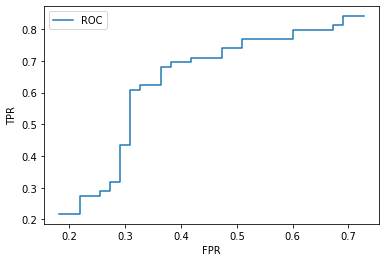

In [13]:
plt.xlabel('FPR')
plt.ylabel('TPR')

plt.plot(FPR, TPR, label='ROC')

plt.legend()

plt.savefig('Curve/ProROC.png', dpi=1200)
plt.show

### AUC_ROC

In [14]:
from sklearn.metrics import roc_curve, auc
roc_auc = auc(FPR,TPR)

print(roc_auc)

0.3470355731225297


### Confusion Matrix

In [15]:
TH=0.5

TP = 0
FN = 0
TN = 0
FP = 0

j = 800
while j < 924:
    result = out[j].item()
    if result>=TH and DJI_Y1[j].item()==1.0:
        TP+=1
    if result>=TH and DJI_Y1[j].item()==0.0:
        FP+=1
    if result<TH and DJI_Y1[j].item()==0.0:
        TN+=1
    if result<TH and DJI_Y1[j].item()==1.0:
        FN+=1
    j+=1
    
print(TP, ' ', FP)
print(FN, ' ', TN)

44   20
25   35
